# READ DATA AND PREPROCESSING

###### READ DATA FROM .CSV AND DO SOME DATA PREPROCESSING, SUCH AS DEAL WITH MISSING VALUE, DATETIME FORMAT ... ETC..

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing 
from keras.optimizers import SGD

#os.chdir(os.path.join(os.getcwd(), 'australia mosquito'))

df = pd.read_csv('test1.csv')
df = df.replace({'12:31': '12:30', '10:24': '10:15', '11:31':'11:30', '11:01':'11:00', '07:56':'07:45', '09:51':'09:45'})
df['Date'] = df[['date','start']].agg(' '.join, axis=1)
df.Date = pd.to_datetime(df.Date)
df = df.sort_values('Date')

tide = pd.read_csv('RCC_Pannikin Is.-July 2018 to May 2020.csv')
tide[['Weekday','Month','Day','Year','Time','apm']] = tide['Time (Australia/Queensland)'].str.split(expand=True)
tide['Date'] = tide[['Month','Day','Year','Time','apm']].agg(' '.join, axis=1)
tide['Date'] = pd.to_datetime(tide['Date'], format = '%b %d, %Y %I:%M %p')
tide = tide[['Date','Raw Distance (m)','Water Level (3.392 m Offset)']]
#tide['year'] = tide['Date'].dt.year
#tide['month'] = tide['Date'].dt.month
#tide['day'] = tide['Date'].dt.day
#tide['hour'] = tide['Date'].dt.hour
#tide['minute'] = tide['Date'].dt.minute
tidetime = pd.date_range(datetime(2019, 12, 1, 0, 0), datetime(2020, 1, 20, 0, 0), freq='15min').to_pydatetime().tolist()
averagetide1 = []
averagetide2 = []
for i in range(len(tidetime)-1):
    temp = tide[(tide['Date']>=tidetime[i])&(tide['Date']<=tidetime[i+1])]
    averagetide1.append(temp['Raw Distance (m)'].mean())
    averagetide2.append(temp['Water Level (3.392 m Offset)'].mean())
new_tide = pd.DataFrame({'Date':tidetime[:-1], 'Raw Distance (m)':averagetide1, 'Water Level (3.392 m Offset)':averagetide2})
new_tide.fillna(method='ffill', inplace=True)

df = pd.merge(df, new_tide, on=['Date'], how='left')

df.isnull().any()

date                            False
start                           False
end                             False
counter_on                      False
fan_on                          False
co2_on                          False
small                           False
mosquitoes                      False
large                           False
temperature                     False
rel_hum                         False
amb_light                       False
battery                         False
reception                       False
latitude                        False
longitude                       False
precipation                     False
moonphase                       False
power_draw                      False
Date                            False
Raw Distance (m)                False
Water Level (3.392 m Offset)    False
dtype: bool

CHOOSE SPECIFIC COLUMN AND SEPERATE DATA TO DECEMBER AND JANUARY

In [5]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['hour'] = pd.DatetimeIndex(df['start']).hour
column = ['mosquitoes', 'month', 'hour', 'temperature', 'rel_hum', 'battery', 'moonphase', 'power_draw', 'reception', 'Raw Distance (m)', 'Water Level (3.392 m Offset)']
df_12 = df[df['month']==12]
df_01 = df[df['month']==1]
df2 = df[column]
df2_12 = df2[df2['month']==12]
df2_01 = df2[df2['month']==1]
df2_notide = df[['mosquitoes', 'month', 'hour', 'temperature', 'rel_hum', 'battery', 'moonphase', 'power_draw', 'reception']]
df2_12_notide = df2_notide[df2_notide['month']==12]
df2_01_notide = df2_notide[df2_notide['month']==1]
df2_notide_5 = df[['mosquitoes', 'month', 'hour', 'temperature', 'moonphase']]

HEAT MAP

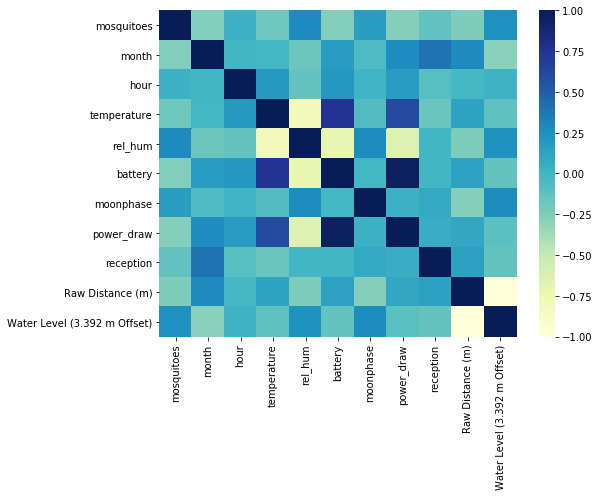

In [6]:
# 獲取相關度資料
corr_pd = df2.corr()
#使用seaborn做視覺化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# 指定畫幅
plt.figure(figsize=(8,6))
# 繪製熱力圖
sns.heatmap(corr_pd, cmap='YlGnBu')

MOSQUITO TREND

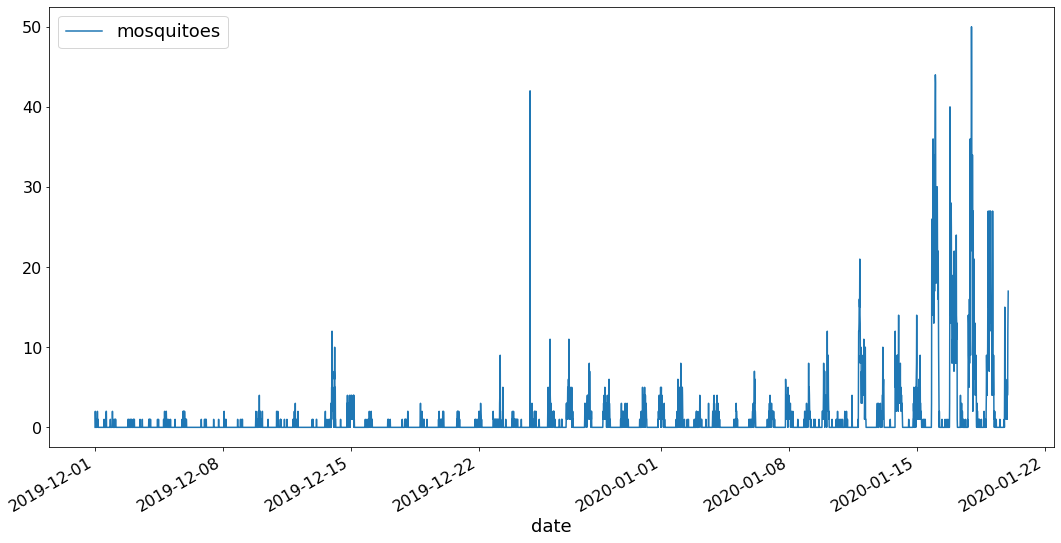

In [7]:
dfplot = df[['Date','mosquitoes']]
dfplot = dfplot.set_index('Date')
dfplot.plot(figsize = (18,9), fontsize=16)
plt.xlabel('date', fontsize=18)
plt.legend(fontsize=18)

# BUILD MODEL

###### TRY SEVERAL MODELS, SUCH AS ONE-TO-ONE MODEL, MANY-TO-ONE MODEL, MANY-TO-MANY MODEL, AND COMPARE.

DEFINE FUNCTION AND MODEL

In [8]:
compare = []
little_compare = []
def normalize(train):
    x = train.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
#     scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    dfx = pd.DataFrame(x_scaled,columns=list(train.columns))
    return dfx
def buildTrain(train, pastDay=3, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(train[i+pastDay:i+pastDay+futureDay]["mosquitoes"]))
    return np.array(X_train), np.array(Y_train)
def shuffle(X,Y):
    #np.random.seed(10)
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*(1-rate))]
    Y_train = Y[:int(Y.shape[0]*(1-rate))]
    X_val = X[int(X.shape[0]*(1-rate)):]
    Y_val = Y[int(Y.shape[0]*(1-rate)):]
    return X_train, Y_train, X_val, Y_val
def normalize_month(train):
#     train = train.drop(["D"], axis=1)
    train = train.drop(["month"], axis=1)
    x = train.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
#     scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    dfx = pd.DataFrame(x_scaled,columns=list(train.columns))
    return dfx
def onetoone(shape):
    model = Sequential()
    model.add(LSTM(units = 16, return_sequences = True, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.1))
    model.add(LSTM(units = 16))
    model.add(Dropout(0.1))
    model.add(Dense(5,activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer='adam')
    model.summary()
    return model
def manytoone(shape):
    model = Sequential()
    model.add(LSTM(16, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #model.add(Dense(5,activation='linear'))
    model.add(Dense(5,activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model
def manytomany(shape):
    model = Sequential()
    model.add(LSTM(16, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

USE ONE TO ONE MODEL ON ALL DATA WITH TIDE

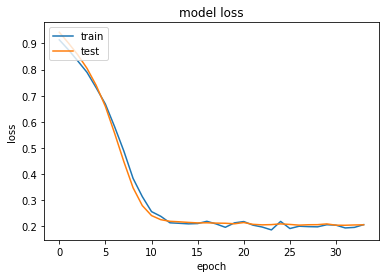

MSE error for LSTM averaging: 28.63102


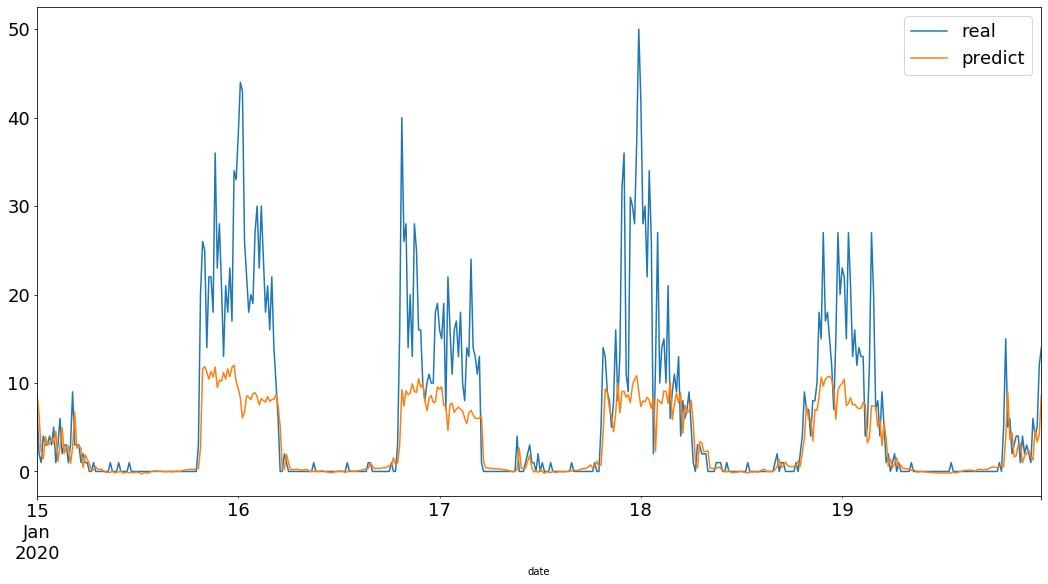

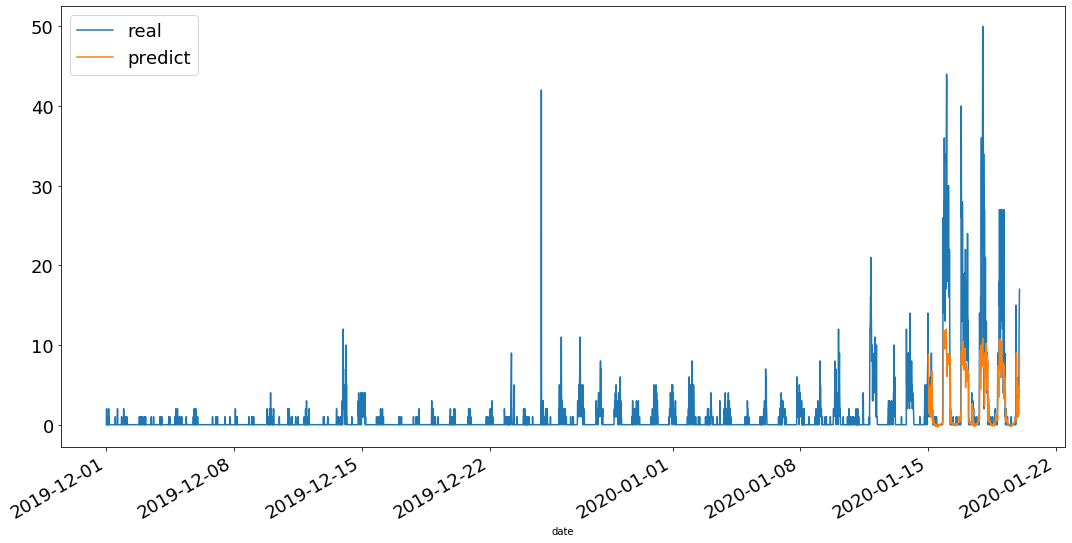

In [19]:
train_norm = normalize_month(df2)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model3 = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model3.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model3.predict(X_val)

x = df2.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0,0,0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0,0,0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_01[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df['Date']),'real':list(df['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

compare.append(0.5*np.mean(mse_errors))

USE MANY TO ONE (3 TO 1) MODEL ON ALL DATA WITH TIDE

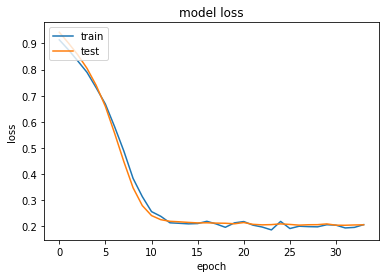

MSE error for LSTM averaging: 52.15947


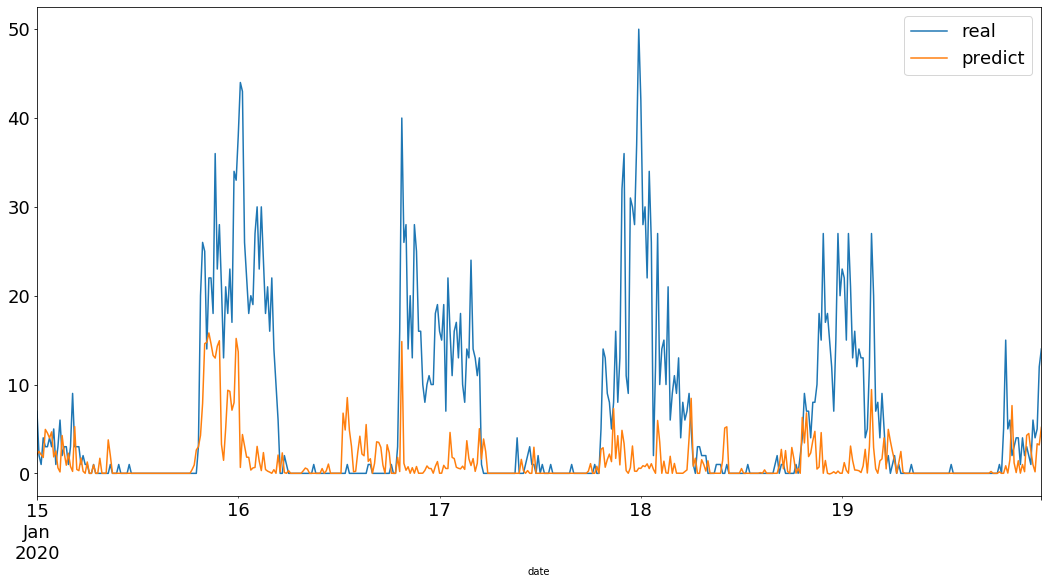

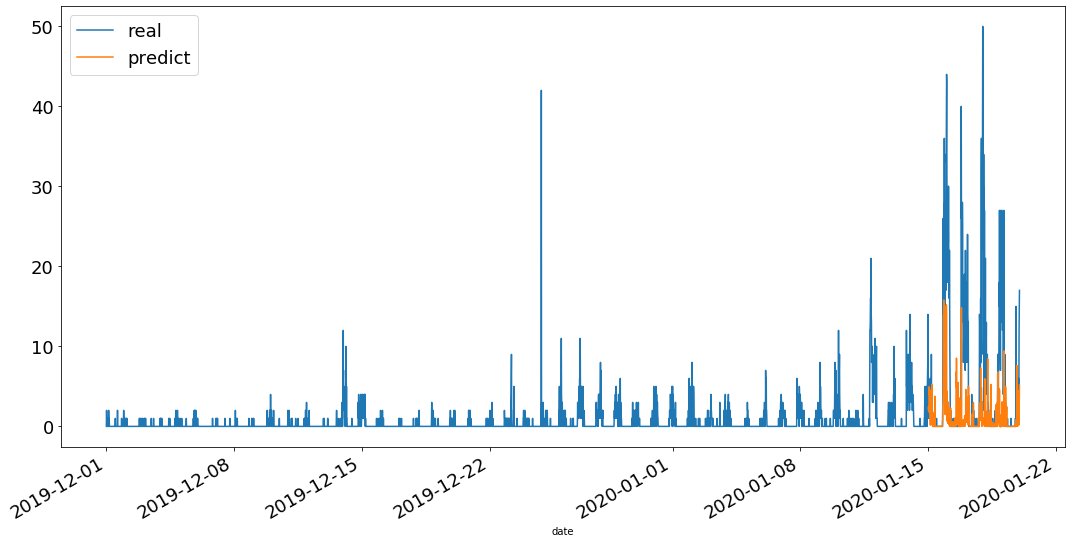

In [20]:
train_norm = normalize_month(df2)
X_train, Y_train = buildTrain(train_norm, 3, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model4 = manytoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model4.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model4.predict(X_val)

x = df2.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0,0,0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0,0,0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df['Date']),'real':list(df['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

compare.append(0.5*np.mean(mse_errors))

USE MANY TO MANY (3 TO 3) MODEL ON ALL DATA WITH TIDE

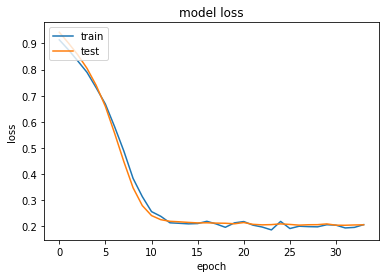

MSE error for EMA averaging: 47.45203


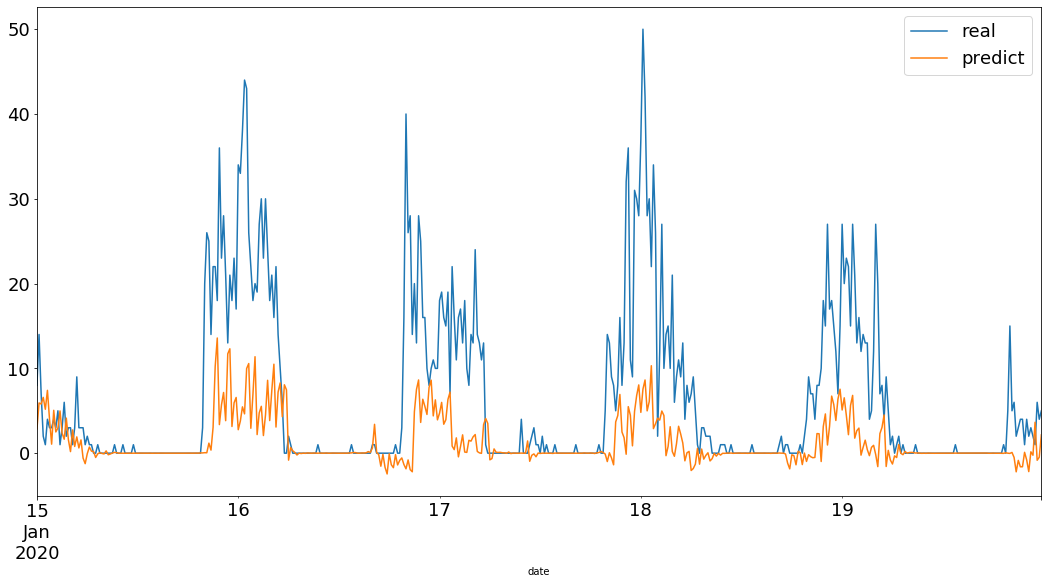

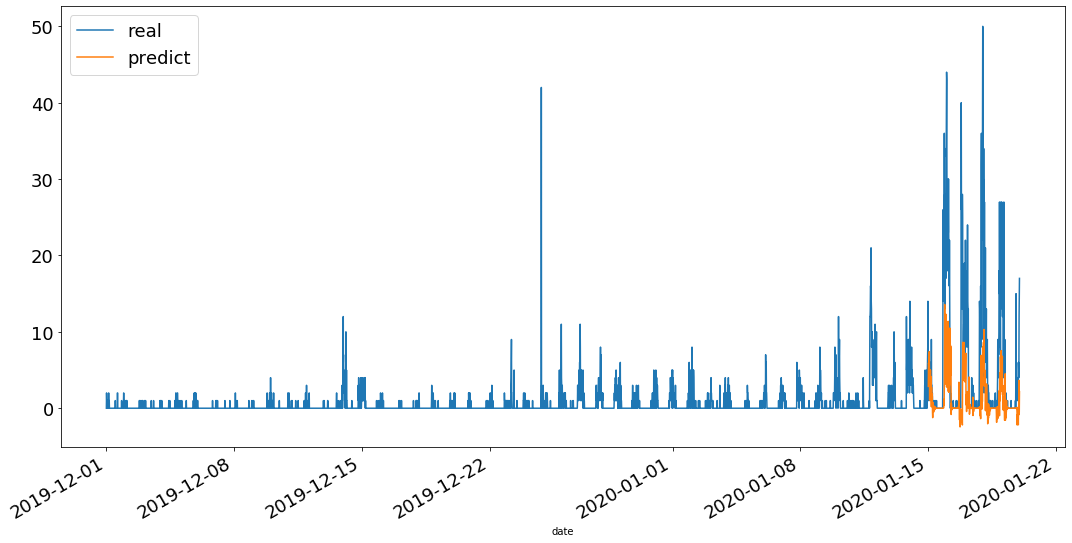

In [21]:
train_norm = normalize_month(df2)
X_train, Y_train = buildTrain(train_norm, 3, 3)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model5 = manytomany(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model5.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model5.predict(X_val)

x = df2.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(int(len(predict)/3)):
    for j in range(3):
        a = predict[i*3][j]
        aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0,0,0])
        list_pre.append(aa[0][0])
        #list_pre.append(aa[0][0])
list_real = []
for i in range(int(Y_val.shape[0]/3)):
    for j in range(3):
        b = Y_val[i*3][j]
        bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0,0,0])
        list_real.append(bb[0][0])
        #list_real.append(bb[0][0])
mse_errors = []
for pred_idx in range(int(len(X_val)/3)*3):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df['Date']),'real':df['mosquitoes'],'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

compare.append(0.5*np.mean(mse_errors))

USE ONE TO ONE MODEL ON ALL DATA WITHOUT TIDE

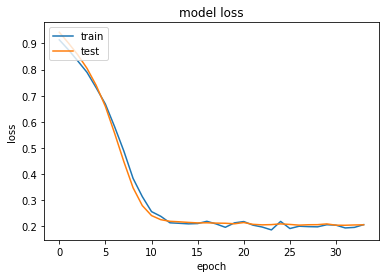

MSE error for LSTM averaging: 32.50691


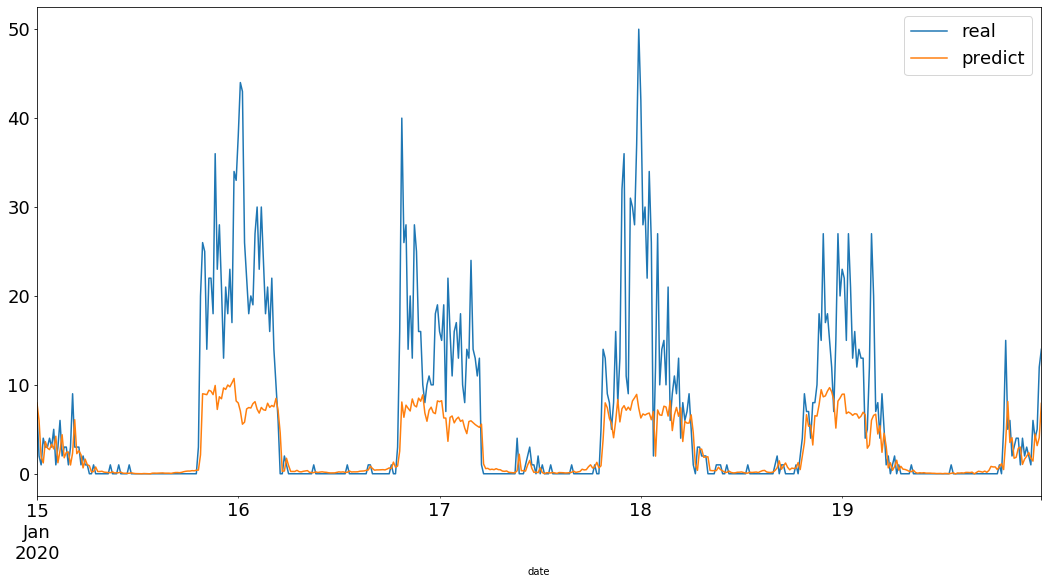

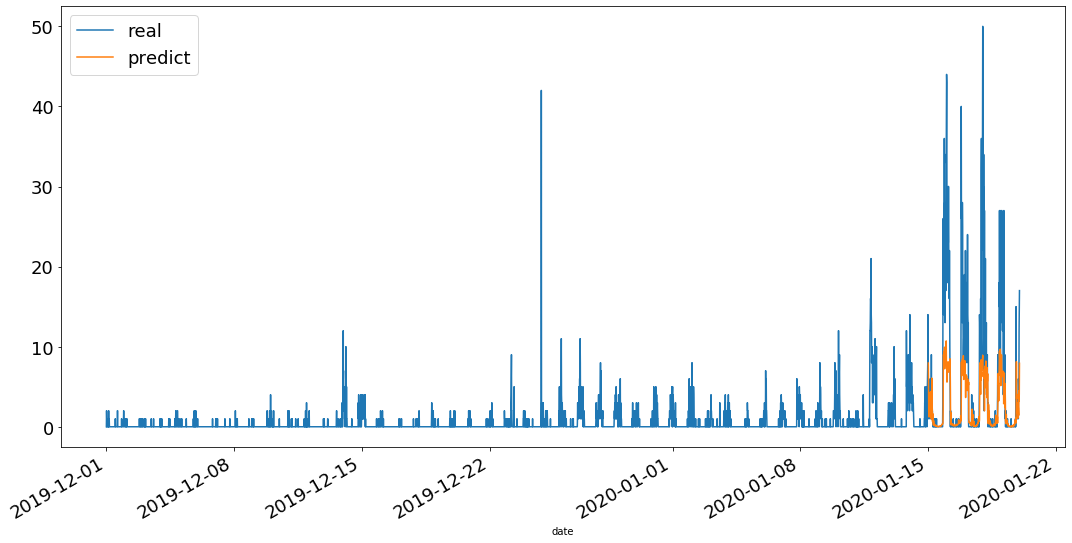

In [22]:
train_norm = normalize_month(df2_notide)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model6 = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model6.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model6.predict(X_val)

x = df2_notide.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2_notide.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_01[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df['Date']),'real':list(df['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

compare.append(0.5*np.mean(mse_errors))

###### COMPARE MODEL

In [13]:
print('MSE of one to one model with tide data: ', '%.5f'%compare[0])
print('MSE of one to one model without tide data: ', '%.5f'%compare[3])
print('MSE of many to one model with tide data: ', '%.5f'%compare[1])
print('MSE of many to many model with tide data: ', '%.5f'%compare[2])

MSE of one to one model with tide data:  28.63102
MSE of one to one model without tide data:  32.50691
MSE of many to one model with tide data:  52.15947
MSE of many to many model with tide data:  47.45203


# MORE MODEL TRAINING

###### WE'VE FOUND ONE-TO-ONE MODEL BEST FIT OUR DATA. WE TRY TO IMPROVE OUR MODEL BY SPLIT THE DATA TO DECEMBER AND JANUARY DATA

USE ONE TO ONE MODEL ON DECEMBER DATA WITHOUT TIDE

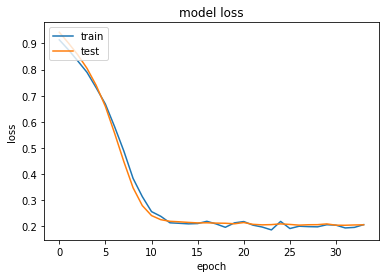

MSE error for LSTM averaging: 0.49931


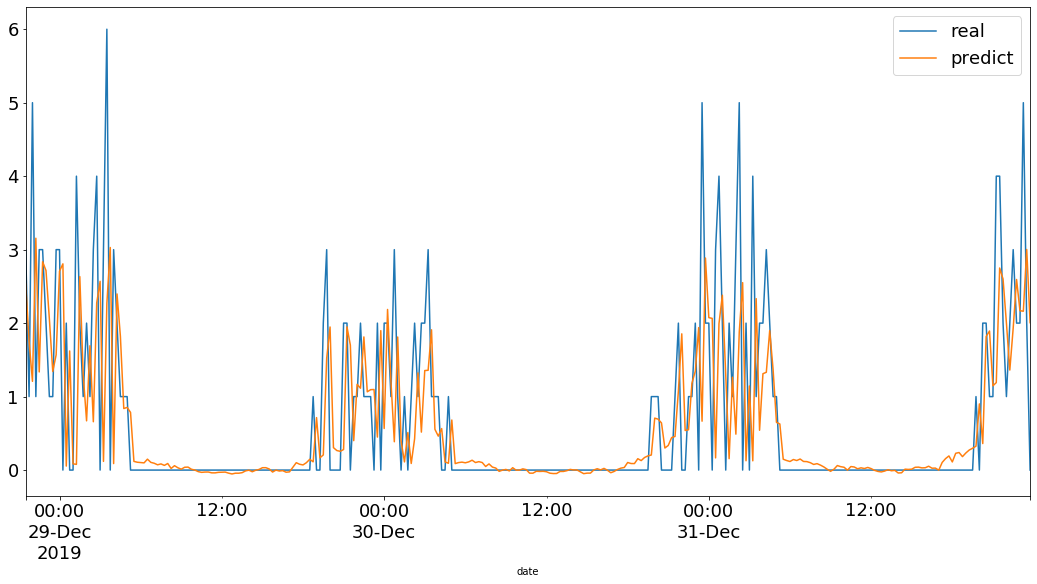

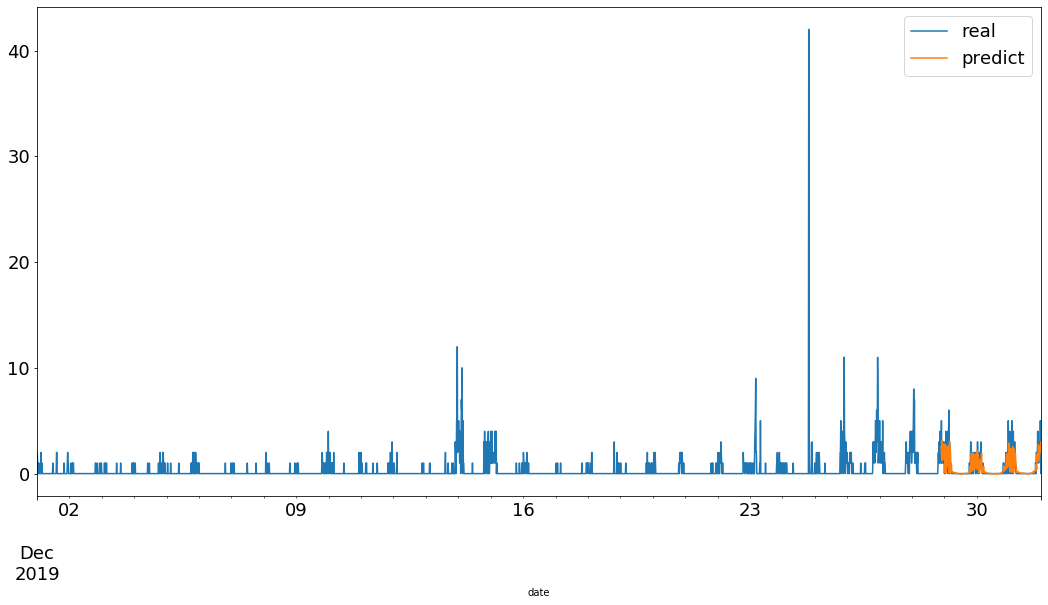

In [23]:
train_norm = normalize_month(df2_12)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model7 = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model7.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x = df2_12.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2_12.columns))

predict = model7.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0,0,0])
    #list_pre.append(aa[0][0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0,0,0])
    #list_real.append(bb[0][0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_12[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df_12)-len(X_val)))
#zeros = np.zeros(len(df_12)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df_12['Date']),'real':list(df_12['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

little_compare.append(0.5*np.mean(mse_errors))

USE ONE TO ONE MODEL ON DECEMBER DATA WITHOUT TIDE

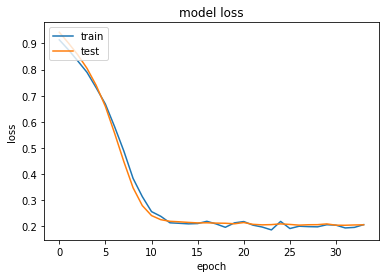

MSE error for LSTM averaging: 0.53722


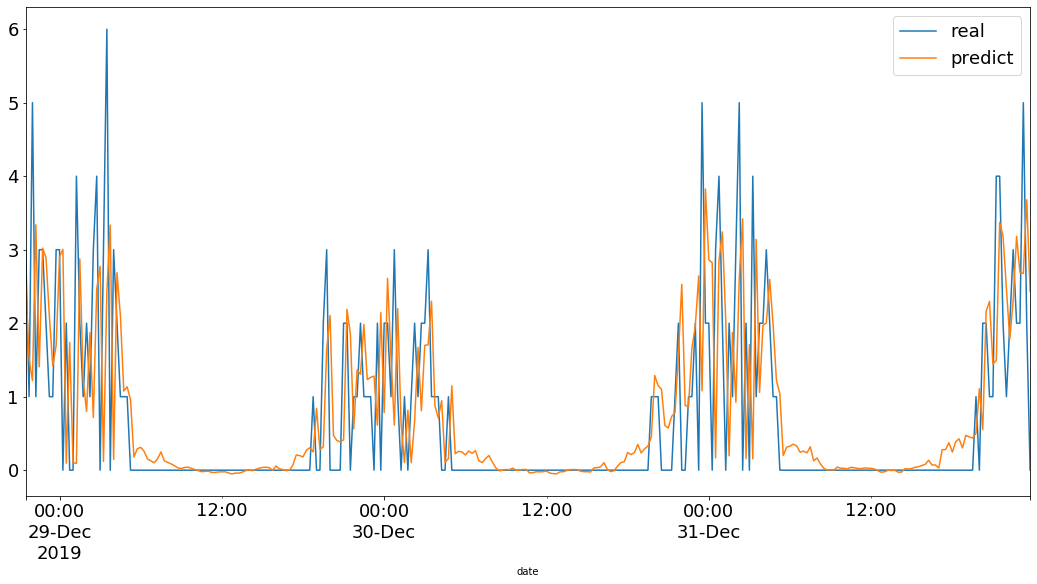

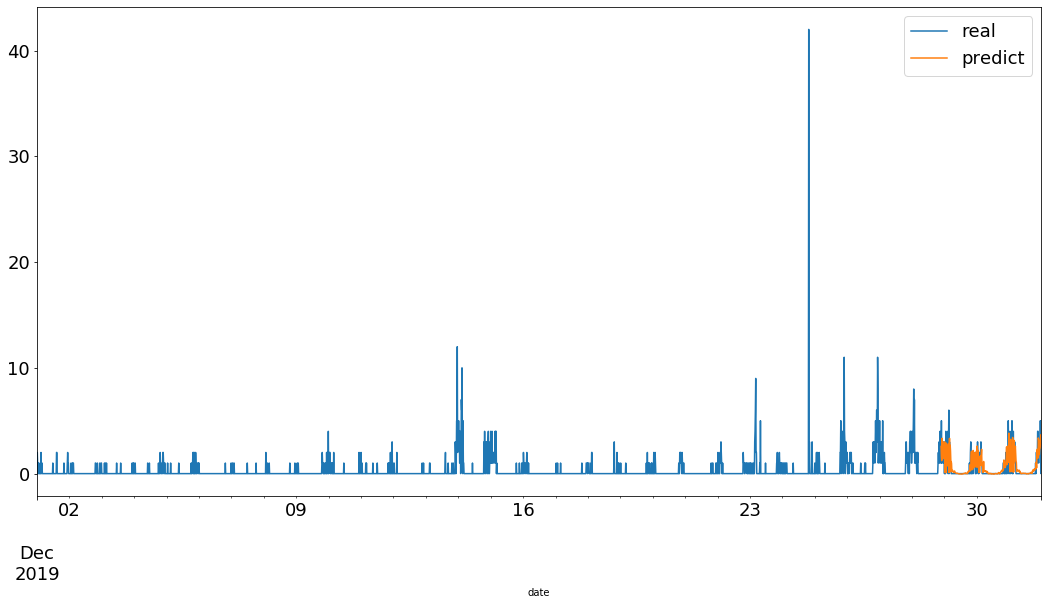

In [24]:
train_norm = normalize_month(df2_12_notide)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x = df2_12_notide.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2_12_notide.columns))

predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0])
    #list_pre.append(aa[0][0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0])
    #list_real.append(bb[0][0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_12[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df_12)-len(X_val)))
#zeros = np.zeros(len(df_12)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df_12['Date']),'real':list(df_12['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

little_compare.append(0.5*np.mean(mse_errors))

USE ONE TO ONE MODEL ON JANUARY DATA WITH TIDE

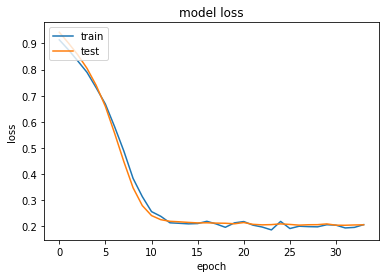

MSE error for LSTM averaging: 7.51196


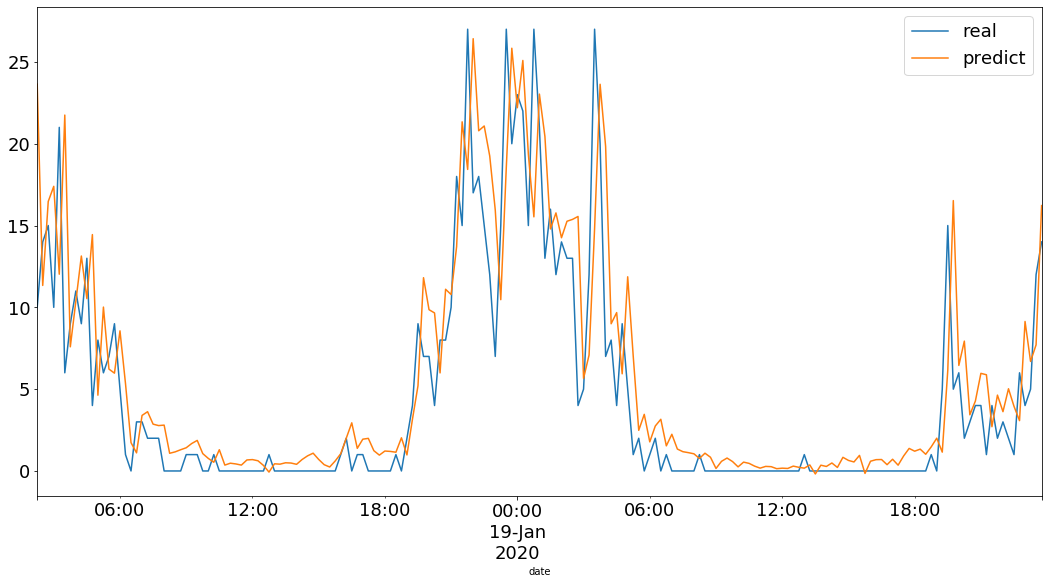

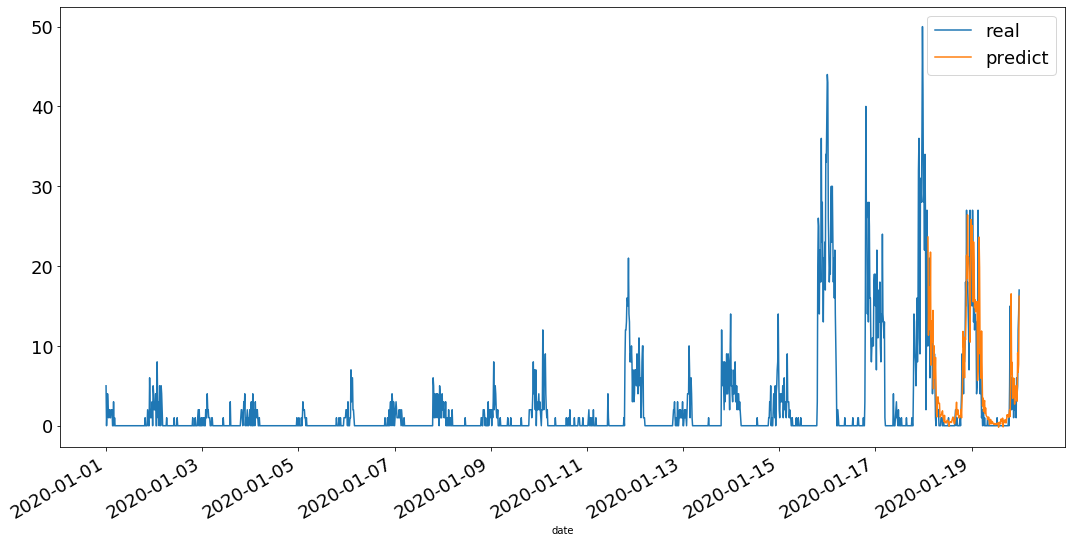

In [25]:
train_norm = normalize_month(df2_01)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model8 = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model8.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model8.predict(X_val)

x = df2_01.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2_01.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0,0,0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0,0,0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_01[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df_01)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df_01['Date']),'real':list(df_01['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

little_compare.append(0.5*np.mean(mse_errors))

USE ONE TO ONE MODEL ON JANUARY DATA WITHOUT TIDE

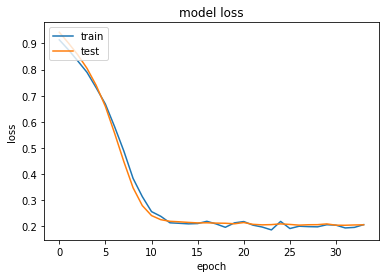

MSE error for LSTM averaging: 7.57743


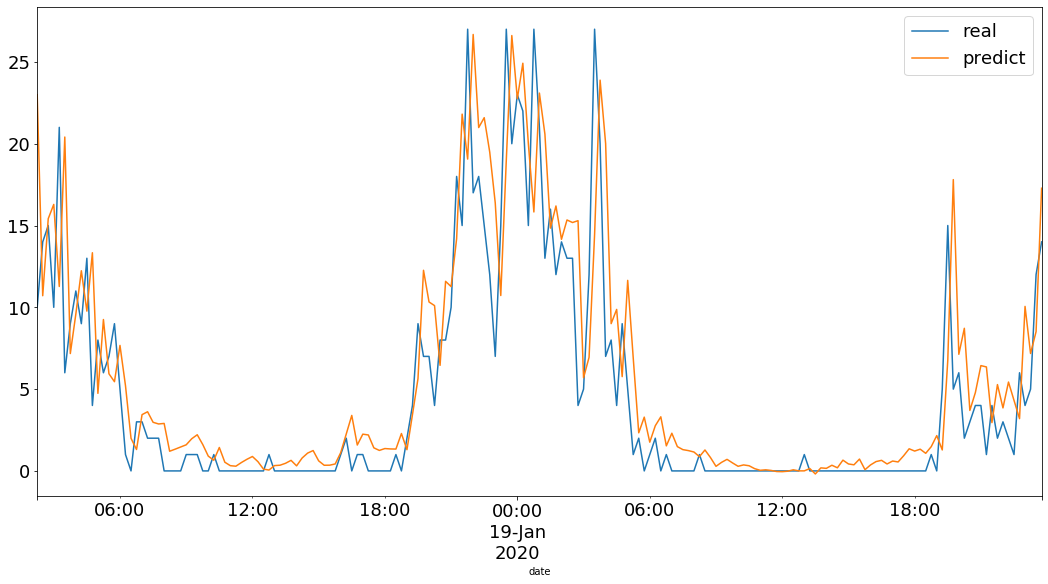

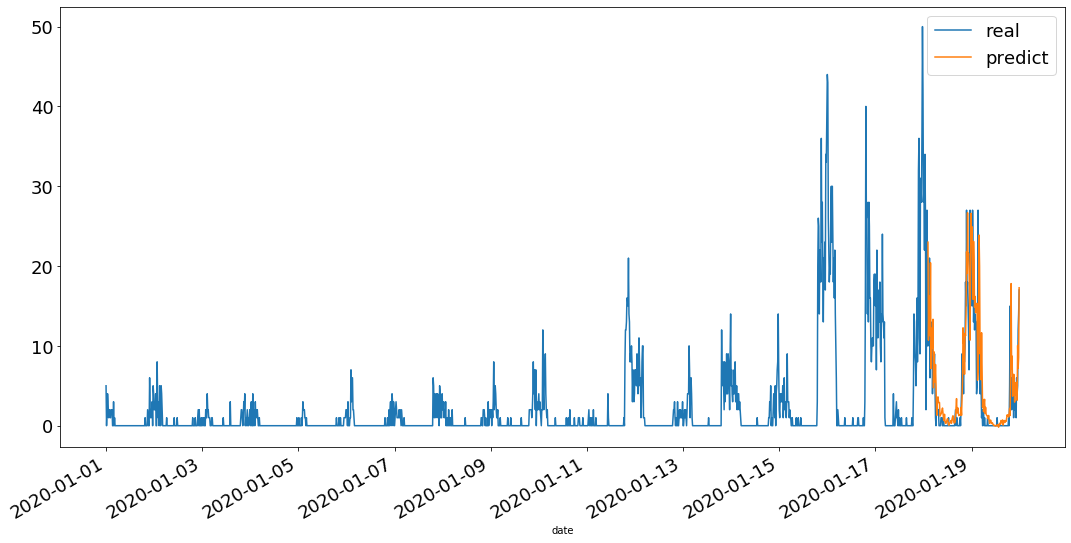

In [26]:
train_norm = normalize_month(df2_01_notide)
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train, Y_train = shuffle(X_train, Y_train)

#Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
#Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)

#model1 = onetoone(X_train.shape)
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#history = model1.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])
history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model1.predict(X_val)

x = df2_01_notide.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df2_01_notide.columns))

#predict = model.predict(X_val)
list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0,0,0,0])
    list_pre.append(aa[0])
list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0,0,0,0])
    list_real.append(bb[0])
    
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for LSTM averaging: %.5f'%(0.5*np.mean(mse_errors)))

datelist = list(df_01[-(len(X_val)):]['Date'])
inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

nulls = np.array([None] * (len(df_01)-len(X_val)))
#zeros = np.zeros(len(df_01)-len(X_val))
realnp = np.concatenate((nulls, np.array(list_real)))
prenp = np.concatenate((nulls, np.array(list_pre)))
inversepredict_df = pd.DataFrame({'date':list(df_01['Date']),'real':list(df_01['mosquitoes']),'predict':prenp})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})

little_compare.append(0.5*np.mean(mse_errors))

###### COMPARE RESULTS

In [18]:
print('one to one model on december data with tide: ', '%.5f'%little_compare[0])
print('one to one model on december data without tide: ', '%.5f'%little_compare[1])
print('one to one model on january data with tide: ', '%.5f'%little_compare[2])
print('one to one model on january data without tide: ', '%.5f'%little_compare[3])

one to one model on december data with tide:  0.49931
one to one model on december data without tide:  0.53722
one to one model on january data with tide:  7.51196
one to one model on january data without tide:  7.57743
